In [1]:
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

import polars as pl

In [2]:
class CustomDataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: list of numpy arrays or torch tensors
        # labels: list of scalars
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)  # or long, depending on your task

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
training_dataset = torch.load("../data/2_ready_for_training/embedded/train_dataset_small.pth")
testing_dataset = torch.load("../data/2_ready_for_training/embedded/test_dataset_small.pth")
val_dataset = torch.load("../data/2_ready_for_training/embedded/val_dataset_small.pth")

/tmp/ipykernel_10909/4200277145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset = torch.load("../data/2_ready_for_training/embedded/train_dataset_small.

In [4]:
len(val_dataset), len(testing_dataset), len(training_dataset)

(622, 1952, 10403)

In [5]:
# Define a simple two-layer neural net with dropout and layer norm
class SmallEmbeddingNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SmallEmbeddingNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


In [6]:
input_dim = int(testing_dataset.X[0].shape[0])
hidden_dim = int(testing_dataset.X[0].shape[0]/2)

In [7]:
model = SmallEmbeddingNeuralNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
model = model.to("cuda")

In [8]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


In [9]:

# TODO  ADD IN LATER BUT NOT YET
#
# class FlatLRScheduler(_LRScheduler):
#     def __init__(self, optimizer: Optimizer, schedule: list, last_epoch: int = -1):
#         """
#         Custom Learning Rate Scheduler.
#
#         Args:
#             optimizer (Optimizer): Wrapped optimizer.
#             schedule (list): List of tuples defining (epoch_range, lr_value).
#                              Example: [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
#             last_epoch (int): The index of the last epoch. Default is -1.
#         """
#         self.schedule = []
#         total_epochs = 0
#         for epochs, lr in schedule:
#             total_epochs += epochs
#             self.schedule.append((total_epochs, lr))
#         super().__init__(optimizer, last_epoch)
#
#     def get_lr(self):
#         current_epoch = self.last_epoch + 1
#         for end_epoch, lr in self.schedule:
#             if current_epoch <= end_epoch:
#                 return [lr for _ in self.optimizer.param_groups]
#         raise ValueError(f"Epoch {current_epoch} is out of range for the provided schedule.")
#
# Define the schedule: [(9 epochs at 1e-3), (8 epochs at 1e-4), (8 epochs at 1e-5)]
# schedule = [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
# schedule = [(10, 1e-3), (10, 1e-4), (5, 1e-5)]
# schedule = [(15, 1e-3), (16, 1e-4)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR
#
# Initialize the custom scheduler
# scheduler = FlatLRScheduler(optimizer, schedule)


In [10]:
criterion = nn.MSELoss()

In [11]:
num_epochs = 15

In [12]:
# Prepare data loaders
batch_size = 256
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)


In [13]:
train_losses = []
test_losses = []
lr_s = []

for epoch_num in range(num_epochs):

    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(-1), labels)
            # test_loss += loss.item()
            test_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
        avg_loss = test_loss/len(testing_dataset)
        test_losses.append(avg_loss)
        print(f"TEST LOSS: PRE Epoch-{epoch_num}, we have {avg_loss:.4f}")


    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch_num}"):
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # loss = criterion(outputs, labels) # MY MSITAKE - DO NOT DO THIS
        loss = criterion(outputs.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # train_loss += loss.item()
        train_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = train_loss/len(training_dataset) # /len(train_dataset) ?? TODO
    train_losses.append(avg_loss)
    print(f"TRAIN LOSS: On Epoch-{epoch_num}, we have {avg_loss:.4f}")

    # scheduler.step()
    # current_lr = scheduler.get_last_lr()
    # lr_s.append(current_lr)




TEST LOSS: PRE Epoch-0, we have 120.7612


Training Epoch 0:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-0, we have 83.8830
TEST LOSS: PRE Epoch-1, we have 65.0292


Training Epoch 1:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-1, we have 59.8273
TEST LOSS: PRE Epoch-2, we have 47.8749


Training Epoch 2:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-2, we have 44.7827
TEST LOSS: PRE Epoch-3, we have 35.4691


Training Epoch 3:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-3, we have 33.4857
TEST LOSS: PRE Epoch-4, we have 26.4588


Training Epoch 4:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-4, we have 24.8630
TEST LOSS: PRE Epoch-5, we have 19.9568


Training Epoch 5:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-5, we have 18.7907
TEST LOSS: PRE Epoch-6, we have 15.2993


Training Epoch 6:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-6, we have 14.0911
TEST LOSS: PRE Epoch-7, we have 12.3110


Training Epoch 7:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-7, we have 10.6017
TEST LOSS: PRE Epoch-8, we have 9.5609


Training Epoch 8:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-8, we have 7.8505
TEST LOSS: PRE Epoch-9, we have 7.7222


Training Epoch 9:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-9, we have 5.9923
TEST LOSS: PRE Epoch-10, we have 7.0222


Training Epoch 10:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-10, we have 4.7084
TEST LOSS: PRE Epoch-11, we have 6.4155


Training Epoch 11:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-11, we have 4.0836
TEST LOSS: PRE Epoch-12, we have 6.1162


Training Epoch 12:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-12, we have 3.4656
TEST LOSS: PRE Epoch-13, we have 5.8736


Training Epoch 13:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-13, we have 3.2347
TEST LOSS: PRE Epoch-14, we have 5.2361


Training Epoch 14:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-14, we have 2.8958


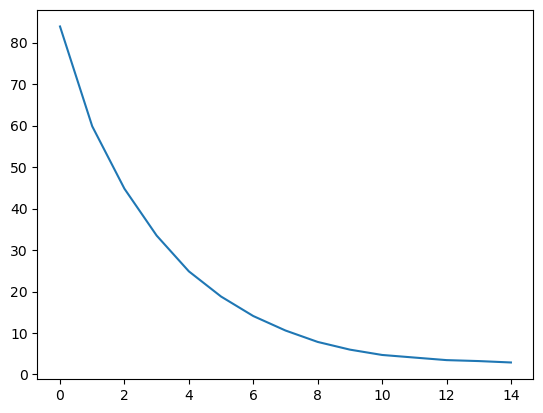

In [14]:
plt.plot(train_losses)

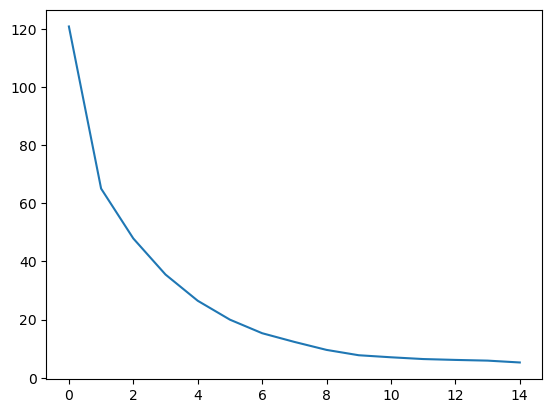

In [15]:

plt.plot(test_losses)

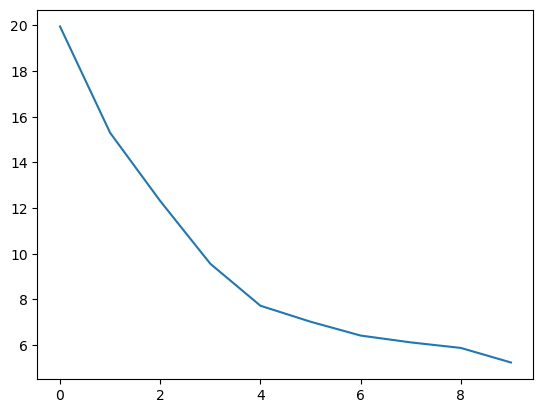

In [16]:
plt.plot(test_losses[-10:])

In [17]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

val_loss = 0.0
model.eval()
with torch.no_grad():
    # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(-1), labels)
        # test_loss += loss.item()
        val_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = val_loss/len(testing_dataset)
    print(f"ON VAL SET, ACHIEVED {avg_loss:.4f}")

ON VAL SET, ACHIEVED 5.6846


In [18]:
val_dataset = torch.load("../data/2_ready_for_training/embedded/val_dataset_small.pth")

# Assuming val_dataset is a list of (inputs, labels)
inputs_list = []
labels_list = []

for item in val_dataset:
    inputs, labels = item  # Unpack inputs and labels
    inputs_list.append(inputs.cpu().numpy())  # Convert tensors to numpy arrays
    labels_list.append(labels.cpu().numpy())

/tmp/ipykernel_10909/3621458664.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_dataset = torch.load("../data/2_ready_for_training/embedded/val_dataset_small.pth")


In [19]:
labels_list_flat = [int(i) for i in labels_list]

In [20]:
# inputs_list_flat = [inp.flatten() for inp in inputs_list]  # Flatten the inputs
# labels_list_flat = [lbl.flatten() for lbl in labels_list]  # Flatten the labels

val_df = pl.DataFrame({
    # "inputs": inputs_list_flat,  # Polars will handle the flat numpy arrays
    "labels": labels_list_flat
})


In [21]:


# Assuming val_dataset, batch_size, and model are already defined
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

val_loss = 0.0
model.eval()
predictions = []  # List to store predictions in order

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(-1), labels)
        val_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size

        # Collect predictions
        predictions.extend(outputs.squeeze(-1).cpu().tolist())

# Compute the average loss
avg_loss = val_loss / len(val_dataset)
print(f"ON VAL SET, ACHIEVED {avg_loss:.4f}")


ON VAL SET, ACHIEVED 3.9208


In [22]:
# Use the predictions to create a Polars column
val_df = val_df.with_columns(pl.Series(predictions).alias("small_embed_predictions"))
val_df.write_csv("../outputs/predictions/small_embed_predictions.csv")

In [23]:
torch.save(model.state_dict(), "../models/embedding/nn_on_small_embeddings.pth")